# Simple flow modeling tutorial

Here I will reproduce an online tutorial found here: https://python.quantecon.org/sir_model.html

This will help with work later modeling the housing supply pipeline.

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numpy import exp

In [2]:
from scipy.integrate import odeint

## The SIR model

We will use a susceptible - infected - removed model to model an epidemic.

States: susceptible (S), exposed (E), infected (I) and removed (R).

Those in R either recovered or died. Those who have recovered gained imunity. Those in the exposed group are not yet infectious.

### Time path

The flow works like this: $$ S \rightarrow E \rightarrow I \rightarrow R $$

Eventually everyone is infected. The question is about _number of infections at a given time_ and _how long the caseload can be deferred until there's a vaccine_.

Lower case letters denote the _fraction_ of the pop in each state. The dynamics are:

$$

\dot{s}(t) = - \beta (t) s(t) i(t) \\

\dot{e}(t) = \beta (t) s(t) i(t) - \sigma e (t) \\

\dot{i}(t) = \sigma e(t) - \gamma i(t)

$$

- $\beta(t)$ is the _transmission rate_ (the rate at which "individuals bump into others and expose them to the virus")
- $\sigma$ is the _infection rate_ i.e. the rate at which those who are exposed become infected
- $\gamma$ is the _recovery rate_ i.e. the rate at which infected people recover or die
- the dot symbol represents the "time derivative $dy/dt$", which means the rate at which the dotted variable changes.

The "removed" fraction is just $ r = 1 - s - e - i $.

And we model the caseload which is $ c = e + i $.

Then the system is written in vector form:

$$

\dot{x} = F(x,t), \qquad x:= (s, e, i)

$$

What does "vector form" mean? Courtesy of my virtual assistant:

"Writing the system in vector form means representing the multiple related equations as a single equation using vectors. This compact representation is useful for several reasons:

1. Simplification: It condenses multiple equations into one concise form.

2. Mathematical analysis: Vector form facilitates certain types of mathematical analysis and manipulation.

3. Computational efficiency: It's often easier to implement vector equations in numerical simulations.

In this case, the system (1.1) is rewritten as:

ẋ = F(x, t),    x := (s, e, i)

Where:
- x is a vector containing the state variables (s, e, i)
- ẋ is the vector of time derivatives (ṡ, ė, i̇)
- F is a vector-valued function that describes how each component of x changes over time

This vector form encapsulates the dynamics of all three variables (susceptible, exposed, infected) in a single equation, making it more convenient for analysis and computation."

That makes sense, as the three variables describe the state of the system in a 3D vector space. I'm sure this allows for lots of linear algebraic cleverness. And the function we are writing (our model) is basically a description of how the vector moves through this space.

Another thing that was not obvious to me: $:=$ is a definition symbol, so "x is defined as the vector of s, e, i".

### Parameters

Sigma and gamma are assumed to be fixed.
- $ \sigma = 1/5.2 $ -- incubation is 5.2 days
- $ \gamma = 1/18 $ -- average illness duration of 18 days

Transmission rate:
- $ \beta (t) := R(t)\gamma $, where R(t) is the effective reporduction number at time t. This is **different** from R, the removed state.

## Implementation

In [3]:
pop_size = 3.3e8 # the population of the US

In [4]:
gamma = 1 / 18
sigma = 1 / 5.2

In [5]:
def F(x, t, R0 = 1.6):
    """
    Time derivative of the state vector.

    x is the state vector (array_like)
    t is time (scalar)
    R0 is the effective transmission rate, defaulting to a constant
    """

    s, e, i = x

    # new exposure of susceptibles
    beta = R0(t) * gamma if callable (R0) else R0 * gamma # so we allow R0 to be a function
    ne = beta * s * i

    # time derivatives -- these are just the equations defined above, presumably for a single time step?
    ds = -ne
    de = ne - sigma * e
    di = sigma * e - gamma * i

    return ds, de, di # we return the derviatives


In [6]:
# initial conditions of s, e, i

i_0 = 1e-7
e_0 = 4*i_0
s_0 = 1 - i_0 - e_0

# in vector form:

x_0 = s_0, e_0, i_0

"We solve the path numerically using odeint, at a sequence of dates t_vec". Ok, what is odeint?

Again, my trusted advisor says:

"Certainly. Let's break down the last step and explain the integration process and the use of `odeint`:

1. Integration Process:
   The function `solve_path` is designed to solve the system of differential equations numerically over time. It uses the `odeint` function from SciPy to perform this integration.

2. What is `odeint`?
   `odeint` stands for "Ordinary Differential Equation Integration". It's a function from SciPy's integrate module that numerically integrates a system of ordinary differential equations.

3. How `odeint` is used here:
   - `G = lambda x, t: F(x, t, R0)`: This creates a function `G` that wraps the `F` function, fixing the `R0` parameter.
   - `odeint(G, x_init, t_vec)`: This call integrates the system defined by `G`, starting from the initial conditions `x_init`, over the time points specified in `t_vec`.

4. What the integration does:
   It computes the values of s, e, and i (susceptible, exposed, infected) at each time point in `t_vec`, given the initial conditions and the dynamics defined by the function `F`.

5. Output processing:
   - `.transpose()`: This transposes the output of `odeint` to separate s, e, and i paths.
   - `c_path = 1 - s_path - e_path`: This calculates the cumulative cases path.

6. Return values:
   The function returns `i_path` (the infected population over time) and `c_path` (the cumulative cases over time).

This numerical integration approach is used because the system of differential equations doesn't have a simple analytical solution. By using `odeint`, we can obtain approximate solutions for the time evolution of the epidemic model."

In [7]:
def solve_path(R0, t_vec, x_init=x_0):
    """
    Solve for i(t) and c(t) via numerical integration, given the time path for R0.
    """

    G = lambda x, t: F(x, t, R0)
    s_path, e_path, i_path = odeint(G, x_init, t_vec).transpose()

    c_path = 1 - s_path - e_path #cumulative cases
    return i_path, c_path

## Experiments

In [10]:
t_length = 550 # around 18 months
grid_size = 1000 # resolution of the simulation
t_vec = np.linspace(0, t_length, grid_size)

### experiment 1: Constant R0

In [18]:
R0_vals = np.linspace(1.6, 3.0, 6) # generate 6 values by linear division of space between 1.6 and 3.0
labels = [f'$R0 = {r: .2f}$' for r in R0_vals] # the $ signs just trigger Latex
i_paths, c_paths = [], []

for r in R0_vals:
    i_path, c_path = solve_path(r, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

In [14]:
# some code to plot the time paths

def plot_paths(paths, labels, times=t_vec):
    
    fig, ax = plt.subplots()

    for path, label in zip(paths, labels):
        ax.plot(times, path, label=label)

    ax.legend(loc='upper left')

    plt.show()

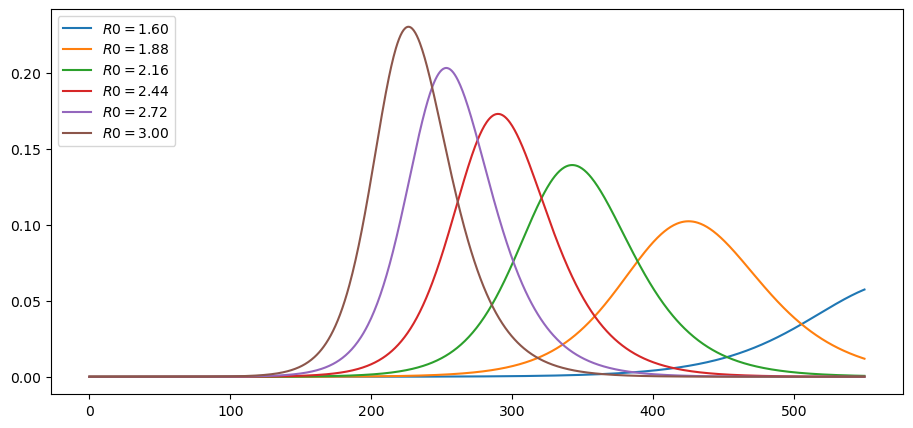

In [19]:
plot_paths(i_paths, labels)

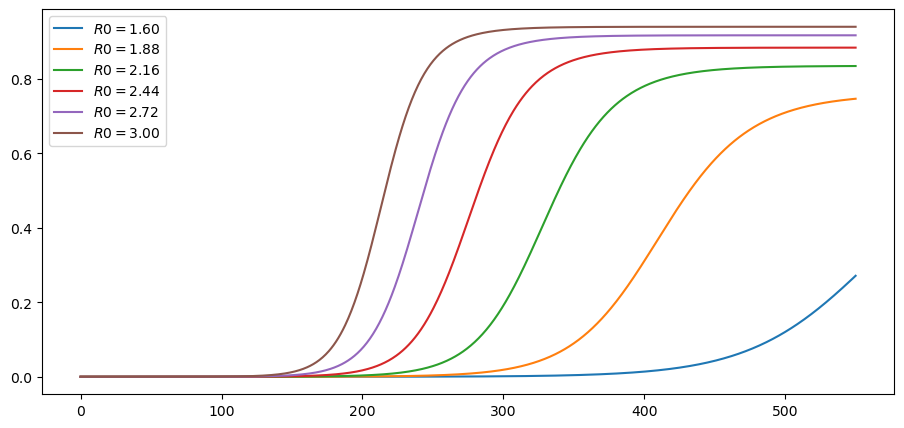

In [20]:
plot_paths(c_paths, labels)

### Experiment 2: changing mitigation

Modelling social distancing.

In [24]:
#R0 starts at 3 and falls to 1.6

def R0_mitigating(t, r0=2, eta = 1, r_bar = 1.6):
    R0 = r0 * exp(- eta * t) + (1 - exp(- eta * t)) * r_bar
    return R0

Went on a little detour trying to understand the exponential function...

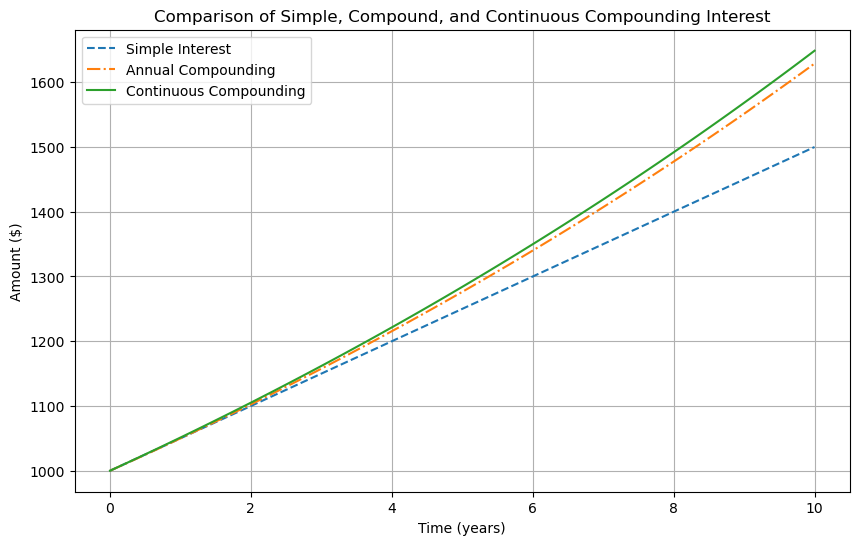

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
P = 1000  # principal amount
r = 0.05  # annual interest rate
t = np.linspace(0, 10, 100)  # time in years

# Calculations
simple_interest = P * (1 + r * t)
annual_compound_interest = P * (1 + r) ** t
continuous_compound_interest = P * np.exp(r * t)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, simple_interest, label='Simple Interest', linestyle='--')
plt.plot(t, annual_compound_interest, label='Annual Compounding', linestyle='-.')
plt.plot(t, continuous_compound_interest, label='Continuous Compounding', linestyle='-')
plt.xlabel('Time (years)')
plt.ylabel('Amount ($)')
plt.title('Comparison of Simple, Compound, and Continuous Compounding Interest')
plt.legend()
plt.grid(True)
plt.show()


Moving on...

In [25]:
# eta controls the rate at which restrictions are imposed, and at which
# rate the effective transmission rate declines

eta_vals = 1/5, 1/10, 1/20, 1/50, 1/100
labels = [fr'$\eta = {eta:.2f}$' for eta in eta_vals]

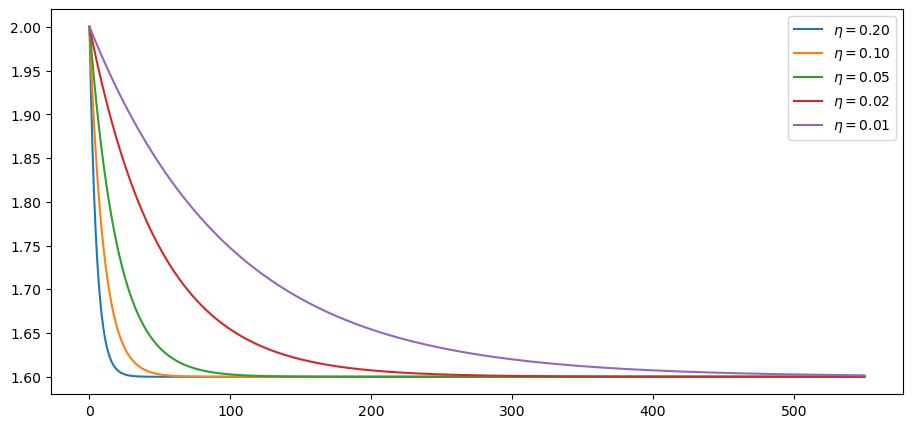

In [30]:
fig, ax = plt.subplots()

for eta, label in zip(eta_vals, labels):
    ax.plot(t_vec, R0_mitigating(t_vec, eta=eta), label=label)

ax.legend()
plt.show()

In [31]:
# calculate time path of infected people
i_paths, c_paths = [], []

# we solve the i_paths and c_paths for all R0 functions with all the eta values
for eta in eta_vals:
    R0 = lambda t: R0_mitigating(t, eta=eta)
    i_path, c_path = solve_path(R0, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

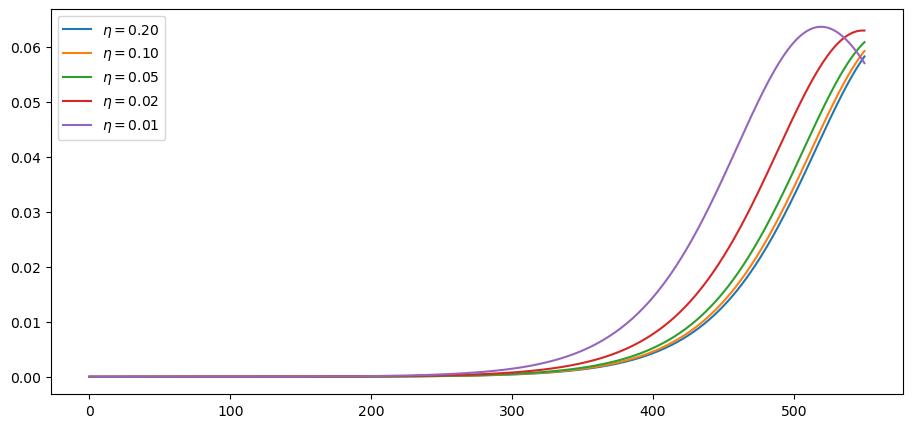

In [34]:
plot_paths(i_paths, labels)

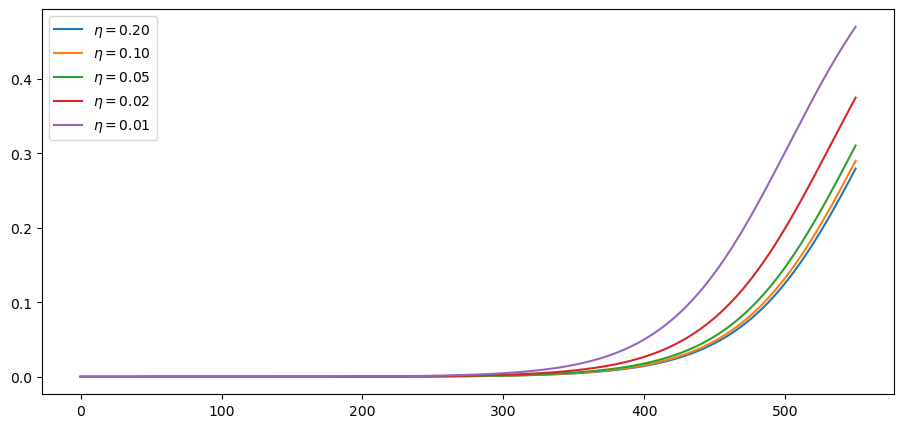

In [33]:
plot_paths(c_paths, labels)

I'm not sure why these look different than the ones in the online version.